In [19]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan
%matplotlib inline

#gm2 = pystan.StanModel(file='./stan/2d-gaussian.stan')

gm2 = pystan.StanModel(file='./stan/2d-gaussian_with_correlation.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_889b1084947e1d379c9ef129719d74d2 NOW.
C:\Users\Andrew\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\AppData\Local\Temp\tmp1ho123ki\stanfit4anon_model_889b1084947e1d379c9ef129719d74d2_5329623520898613525.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [20]:
years = np.arange(1,7,1)
combinations = []
for counter in range(0,6):
    combinations.append(np.delete(years,counter))
print(combinations)

[array([2, 3, 4, 5, 6]), array([1, 3, 4, 5, 6]), array([1, 2, 4, 5, 6]), array([1, 2, 3, 5, 6]), array([1, 2, 3, 4, 6]), array([1, 2, 3, 4, 5])]


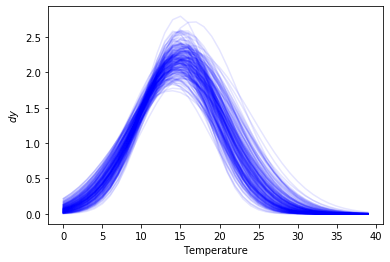

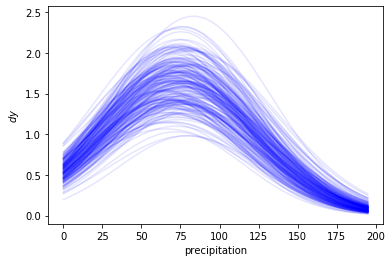

In [21]:

%matplotlib inline


templists,rainlists,yieldlist =[],[],[]

for counter in range(2,7):
    templists.append(np.load('data/Temps'+str(counter)+'.npy'))
    
for counter in range(2,7):
    rainlists.append(np.load('data/Rain'+str(counter)+'.npy'))

for counter in range(2,7):
    yieldlist.append(np.load('data/Yield'+str(counter)+'.npy'))
    
rainlists = np.array(rainlists)
templists = np.array(templists)
yieldlist= np.array(yieldlist)

templists = templists.reshape(5,int(len(templists[0])/12),12)

templists= templists[:,:,4:10]

rainlists = rainlists.reshape(5,int(len(rainlists[0])/12),12)
rainlists= rainlists[:,:,4:10]

data2={
    'n_regions':5,
    'n_years':8,
    'd_temp':templists,
    'd_precip':rainlists,
    'd_yields':yieldlist,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)
}
fit=gm2.sampling(data=data2,chains=4,iter=1000,verbose=True,seed=1308)


samples=fit.extract()


#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy1'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')
plt.show()


#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['precip'],samples['fdy2'][i,:],alpha=0.1, c='b')
plt.xlabel('precipitation')
plt.ylabel(r'$dy$')
plt.show()
#plt.title('Growth Curve')

In [22]:
samples=fit.extract()
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_889b1084947e1d379c9ef129719d74d2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t              15.04    0.02   0.63  13.96  14.61  14.98  15.41  16.47    852    1.0
sigma_t            5.58    0.02   0.74   4.28   5.06   5.53   6.08   7.16    890    1.0
mu_p              73.79    0.15   4.24  64.88   71.1  73.95  76.61  81.67    795   1.01
sigma_p           49.58    0.08   2.92  44.15  47.51  49.51   51.5  55.47   1373    1.0
norm               2.56  4.2e-3   0.11   2.36   2.48   2.55   2.63    2.8    693    1.0
fdy1[1]            0.07  1.6e-3   0.05 7.1e-3   0.03   0.06   0.09    0.2   1000    1.0
fdy1[2]             0.1  2.1e-3   0.07   0.02   0.05   0.09   0.14   0.27    981    1.0
fdy1[3]            0.15  2.7e-3   0.08   0.03   0.09   0.14    0.2   

Text(0, 0.5, 'Monthly precipitation (mm)')

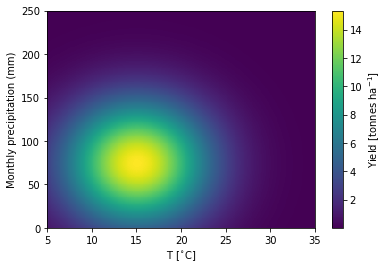

In [23]:

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
fig, ax = plt.subplots()

t1, t2 = 5., 35.
p1, p2 = 0., 250.
x = arange(t1,t2,.1)
y = arange(p1,p2,1.)
X,Y = meshgrid(x, y) # grid of point
def yield_equal(temp, precip, mu_t, sigma_t, mu_p, sigma_p, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    temp_6m = np.full(6, temp)
    precip_6m = np.full(6, precip)
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-0.5 *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                             + np.square((precip_6m[month] - mu_p)/sigma_p) )
                                      )
    return np.sum(dy)
def z_func(X,Y):
    return yield_equal(X, Y, float(np.mean(samples['mu_t'])), float(np.mean(samples['sigma_t'])), float(np.mean(samples['mu_p'])),
       float(np.mean(samples['sigma_p'])), [float(np.mean(samples['norm']))])


z_func = np.vectorize(z_func)
#Lets use the median

Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(np.flip(Z,axis= 0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('T [$^{\circ}$C]')
ax.set_ylabel('Monthly precipitation (mm)')

#plt.savefig('./figs/2d_yield_response.pdf')
#plt.savefig('./figs/2d_yield_response.png')

7.95  Actual Yield
14.414647104349777 54.766995740921494 Average temp/Rain
14.190544904298674  Predicted Yield
Difference =  -6.240544904298674
10.51  Actual Yield
14.944484391925714 41.961273796518434 Average temp/Rain
12.491341693279574  Predicted Yield
Difference =  -1.9813416932795747
12.89  Actual Yield
13.998616599742618 69.58885484800027 Average temp/Rain
15.04024753036808  Predicted Yield
Difference =  -2.1502475303680786
11.18  Actual Yield
14.623573173295455 45.43978041008618 Average temp/Rain
12.925844158529147  Predicted Yield
Difference =  -1.745844158529147
12.54  Actual Yield
15.33100428710746 63.277669398553265 Average temp/Rain
14.972089834761357  Predicted Yield
Difference =  -2.432089834761358
11.69  Actual Yield
14.185968893313694 54.55563823988985 Average temp/Rain
14.123425189859999  Predicted Yield
Difference =  -2.4334251898599994
11.68  Actual Yield
15.50223976964532 48.701213177092306 Average temp/Rain
13.497769020147631  Predicted Yield
Difference =  -1.81776

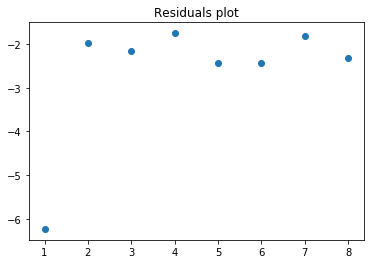

In [24]:
TestTemps = np.load('data/Temps'+str(1)+'.npy')
TestRains = np.load('data/Rain'+str(1)+'.npy')
TestYield = np.load('data/Yield'+str(1)+'.npy')



TestRains = np.split(TestRains,len(TestRains)/12)
TestTemps = np.split(TestTemps,len(TestTemps)/12)

xindex,yindex = [],[]
Residuals = []

for Rain,Temp,Yield in zip(TestRains,TestTemps,TestYield):

    print(Yield, ' Actual Yield')

    xidx = (np.abs(x - np.mean(Temp[4:10]))).argmin()

    yidx = (np.abs(y - np.mean(Rain[4:10]))).argmin()

    print(np.mean(Temp[4:10]),np.mean(Rain[4:10]), 'Average temp/Rain')
    #print(x[xidx],y[yidx], 'Closest value')
    print(Z[yidx,xidx], ' Predicted Yield')
    print('Difference = ', Yield-Z[yidx,xidx])
    xindex.append(x[xidx])
    yindex.append(y[yidx])
    Residuals.append(Yield-Z[yidx,xidx])
    

plt.title('Residuals plot')
plt.scatter(np.arange(1,9),Residuals)
print(np.mean(Residuals))


In [ ]:



'''




from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show


fig, ax = plt.subplots()

t1, t2 = 0., 35.
p1, p2 = 0., 250.
x = np.linspace(t1,t2,100)
y = np.linspace(p1,p2,100)
X,Y = meshgrid(x, y) # grid of point

def yield_equal2(temp, precip, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    temp_6m = np.full(6, temp)
    precip_6m = np.full(6, precip)
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-(1/(2 - 2*rho**2)) *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                                           + np.square((precip_6m[month] - mu_p)/sigma_p) 
                                                           - (2*rho*(temp_6m[month]    - mu_t)
                                                                   *(precip_6m[month] - mu_p)
                                                             )
                                                              /(sigma_t*sigma_p)
                                                           )
                                      )
    return np.sum(dy)



def z_func(X,Y):
    return yield_equal2(X, Y, float(np.mean(samples['mu_t'])), float(np.mean(samples['sigma_t'])), float(np.mean(samples['mu_p'])),
       float(np.mean(samples['sigma_p'])), float(np.mean(samples['rho'])), [float(np.mean(samples['norm']))])


z_func = np.vectorize(z_func)
#Lets use the median

Z = z_func(X, Y) # evaluation of the function on the grid

im = ax.imshow(np.flip(Z, axis=0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function

cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('T (Celsius)')
ax.set_ylabel('Monthly precipitation (mm)')
#plt.savefig('./figs/2d_2.pdf')


'''